# Data Labeling

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

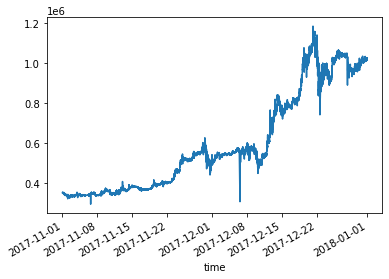

In [ ]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

### Price Change Direction

In [ ]:
# Q. 코드를 작성해주세요

# window 지정
window = 10 # 앞서 사용한 window의 값은 10입니다.

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)  # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal) # 데이터 활용을 위해 pd.Series를 사용합니다.

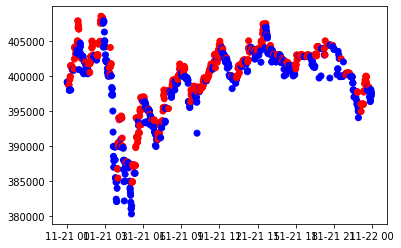

In [ ]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig==1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### Using Moving Average

In [ ]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)

In [ ]:
s_momentum_signal = pd.Series(momentum_signal)

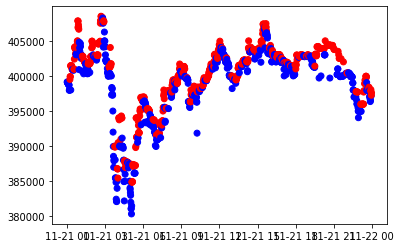

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig==1, 'red', 'blue')
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

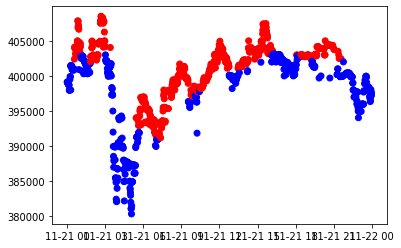

In [ ]:
# 180분봉 기준 이동평균 적용
window=180

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal)

sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig==1, 'red', 'blue')
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### Local Min-Max

In [ ]:
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time':min_idxes, 'local_min':mins}), pd.DataFrame.from_dict({'max_time':max_idxes, 'local_max':maxes})

In [ ]:
mins, maxes = get_local_min_max(sub_data, wait=3)

print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

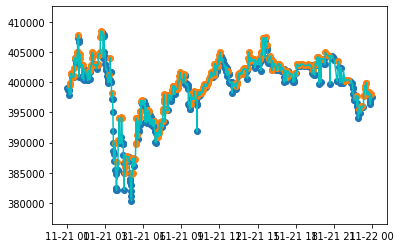

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(sub_data, 'c')

ax.scatter(mins.min_time, mins.local_min)

ax.scatter(maxes.max_time, maxes.local_max)

ax.set_ylim([sub_data.min() * 0.99, sub_data.max() * 1.01])

### Trend Scanning

In [ ]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [ ]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array=[]
t_values_array = []

In [ ]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast = 'signed')

100%|██████████| 33384/33384 [13:06<00:00, 42.44it/s]


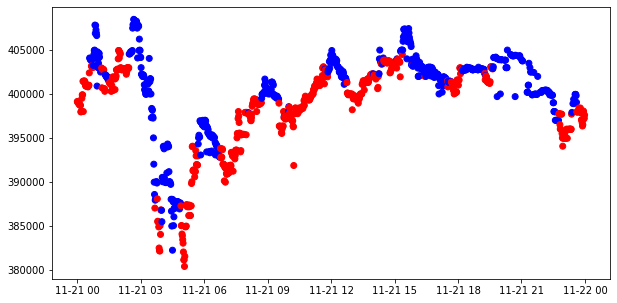

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig==1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# Feature Engineering

In [ ]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### Technical Index

In [ ]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [ ]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [ ]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:,-1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [ ]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier()

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier()

### MDI

In [ ]:
# MDI, Mean Decrease Impurity
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.041185,0.002005
volume_fi,0.044709,0.002266
volume_mfi,0.053439,0.002835
volume_sma_em,0.029927,0.001672
volume_vpt,0.022485,0.001401
volatility_atr,0.072721,0.003361
volatility_ui,0.049378,0.002153
trend_macd_diff,0.092207,0.004745
trend_adx,0.052568,0.002440
trend_trix,0.065189,0.002512


### MDA

In [ ]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [ ]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

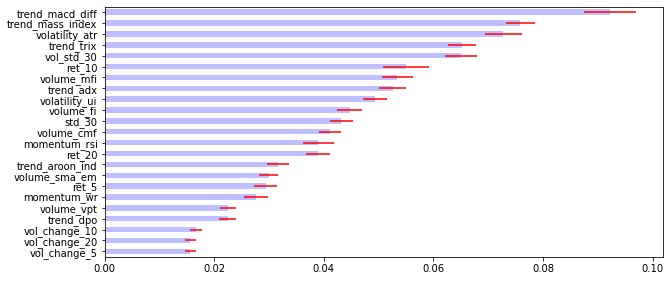

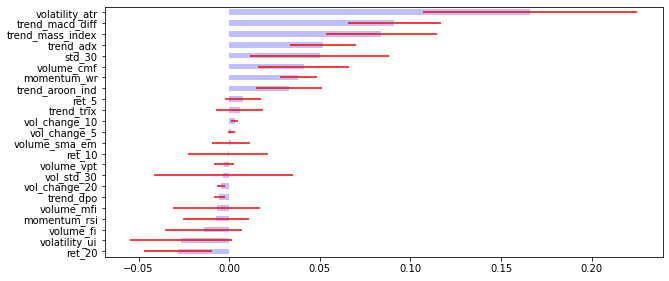

In [ ]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [ ]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=3)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

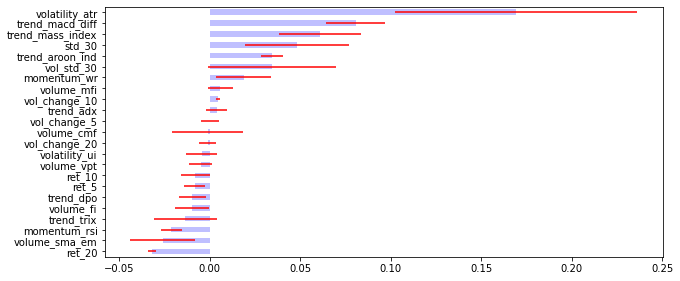

In [ ]:
plot_feature_importance(feat_imp_mda)

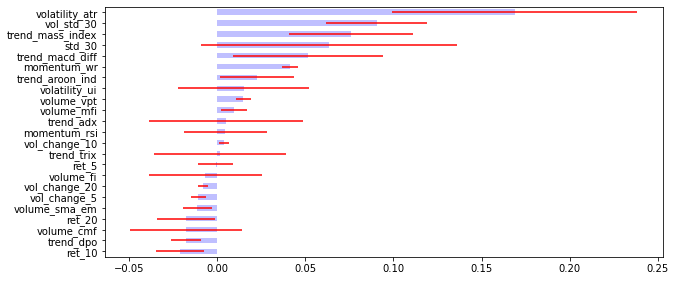

In [ ]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=4)
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

plot_feature_importance(feat_imp_mda)

cv를 3이나 4로 변경했을 때의 결과는
* 조금씩 피처들의 순서가 달라짐
* 가장 큰 영향력을 가지고 있는 volatility_atr은 여전히 1위이고 가장 큰 부분을 차지하고 있음

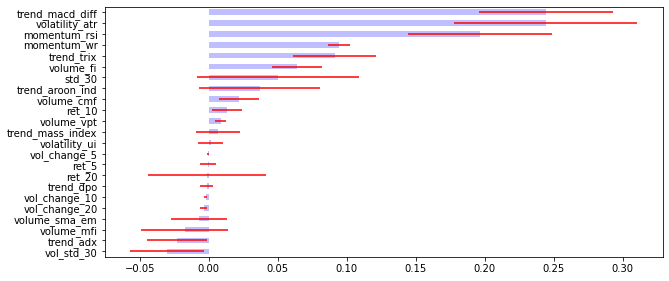

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(lr, X_sc, y, cv_gen=cv)

plot_feature_importance(feat_imp_mda)

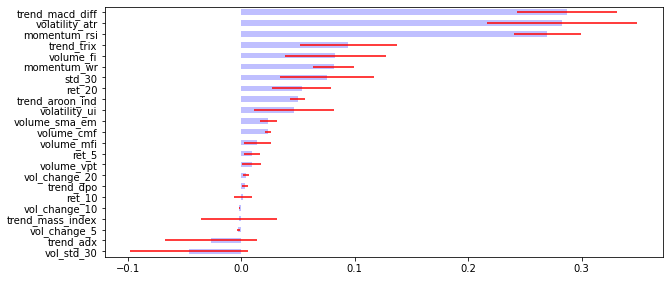

In [ ]:
lr = LogisticRegression()
cv = KFold(n_splits=3)
feat_imp_mda = imp.mean_decrease_accuracy(lr, X_sc, y, cv_gen=cv)

plot_feature_importance(feat_imp_mda)

Logistic Regression을 사용하면
* trend_macd_diff가 가장 큰 영향력을 보이고, cv를 조절하면 비중도 매우 높음을 알 수 있음

[06:48:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:48:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:48:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:48:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

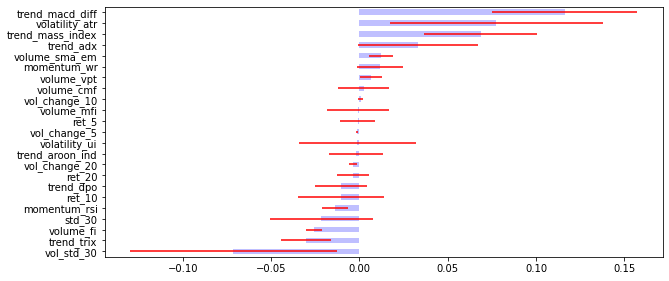

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
cv = KFold(n_splits=5)
feat_imp_mda = imp.mean_decrease_accuracy(xgb, X_sc, y, cv_gen=cv)

plot_feature_importance(feat_imp_mda)

xgboost에서는
* trend_macd_diff가 가장 높은 중요도를 보임을 알 수 있다.
* 세 모델 전부 volatility_atr이 높은 중요도를 보이는 것으로 보아, volatility_atr이 모델링에 충분히 고려되어야 함을 알 수 있다.

### RFE_CV

In [ ]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [ ]:
# 선택된 피쳐 확인하기

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename({0:'Optimal_Features', 1:'Ranking'}, axis=1)
rfe_df[rfe_df['Optimal_Features']==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


In [ ]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [ ]:
# 선택된 피쳐 확인하기

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=['Optimal_Features'])
sfs_df[sfs_df['Optimal_Features']==True]

,Optimal_Features
volume_mfi,True
trend_macd_diff,True


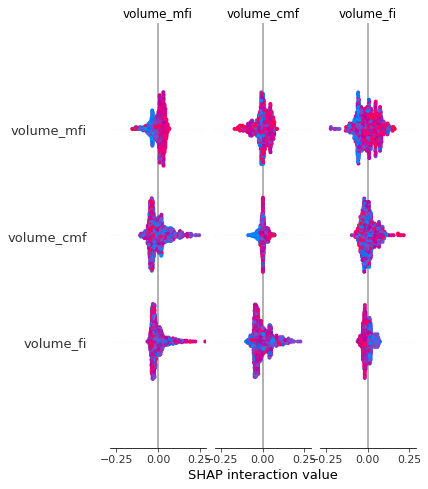

In [ ]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

# Model Training

In [ ]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [ ]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

In [ ]:
# Q. 코드를 작성해주세요

n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

n_cv는 교차 검증의 분할 수이다.

데이터의 크기가 충분히 크고, 시간적 순서를 반영하면서 충분히 다양한 검증을 할 수 있는 최적의 수가 4개이기 때문에, n_cv를 4개로 우선 설정해본다.

In [ ]:
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

In [ ]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [ ]:
# Q. 코드를 작성해주세요

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [ ]:
# Q. 코드를 작성해주세요

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [ ]:
# fit
gs_rfc.fit(train_x, train_y)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns]),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [3, 5, 10, 20],
                         'base_estimator__max_features': [None, 'auto'],
                         'base_estimator__min_samples_leaf': [3, 5, 10],
                         'bootstrap_features': [False, True],
                         'max_features': [0.5, 0.7],
                         'n_estimators': [5, 10, 20]},
             verbose=1)

In [ ]:
# best estimator
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=10,
                                                        max_features=None,
                                                        min_samples_leaf=10),
                  max_features=0.7)

In [ ]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[88 48]
 [12 43]]
정확도:0.6858638743455497, 정밀도:0.4725274725274725, 재현율:0.7818181818181819


auc:0.7144385026737967


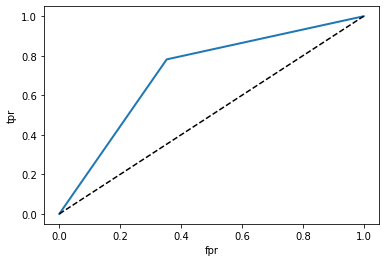

In [ ]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

추가 모델 적용

* randomized search, random forest (no bagging)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'oob_score': [True, False]
}

rs_rfc = RandomizedSearchCV(rfc, rf_params, cv=cv, n_jobs=-1, verbose=1)
rs_rfc.fit(train_x, train_y)

rs_rfc_best = rs_rfc.best_estimator_
rs_rfc_best.fit(train_x, train_y)

pred_y = rs_rfc_best.predict(test_x)
prob_y = rs_rfc_best.predict_proba(test_x)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does 

================= confusion matrix ====================
[[83 53]
 [10 45]]
정확도:0.6701570680628273, 정밀도:0.45918367346938777, 재현율:0.8181818181818182
auc:0.7142379679144386


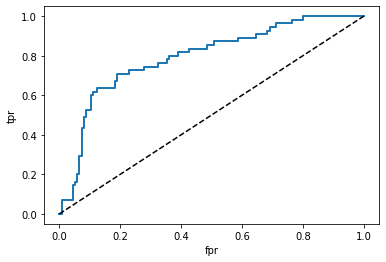

In [ ]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

* logistic regression (no bagging)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

================= confusion matrix ====================
[[80 56]
 [14 41]]
정확도:0.6335078534031413, 정밀도:0.422680412371134, 재현율:0.7454545454545455
auc:0.6668449197860963


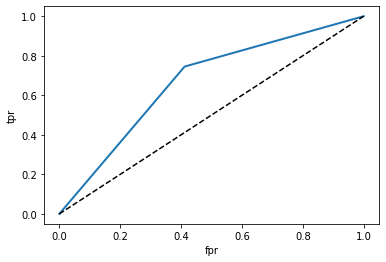

In [ ]:
from scipy.stats import uniform, randint

lr_params = {
    'C': uniform(0.001, 10),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'tol': [1e-4, 1e-3, 1e-2],
    'fit_intercept': [True, False]
}

lr = LogisticRegression()

rs = RandomizedSearchCV(lr, lr_params, cv=cv, n_jobs=-1, verbose=1)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_
rs_best.fit(train_x, train_y)

pred_y = rs_rfc_best.predict(test_x)
prob_y = rs_rfc_best.predict_proba(test_x)


confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

* Logistic Regression + Bagging

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the

================= confusion matrix ====================
[[79 57]
 [10 45]]
정확도:0.6492146596858639, 정밀도:0.4411764705882353, 재현율:0.8181818181818182
auc:0.8370320855614973


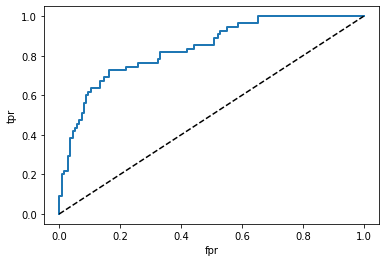

In [ ]:
lr_params = {
    'base_estimator__C': uniform(0.001, 10),
    'base_estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'base_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'base_estimator__max_iter': [100, 200, 300],
    'base_estimator__multi_class': ['auto', 'ovr', 'multinomial'],
    'base_estimator__tol': [1e-4, 1e-3, 1e-2],
    'base_estimator__fit_intercept': [True, False],

    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

lr = LogisticRegression()
bag_lr = BaggingClassifier(base_estimator=lr)

rs = RandomizedSearchCV(bag_lr, lr_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
prob_y = rs_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')


정확도와 정밀도는 0.03 정도씩 감소했지만, 재현율이 0.03 증가했고, auc가 0.12 증가하여 좋은 성능 향상을 보여주었다.

* lightgbm + bagging

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 

================= confusion matrix ====================
[[73 63]
 [ 9 46]]
정확도:0.6230366492146597, 정밀도:0.42201834862385323, 재현율:0.8363636363636363
auc:0.7946524064171123


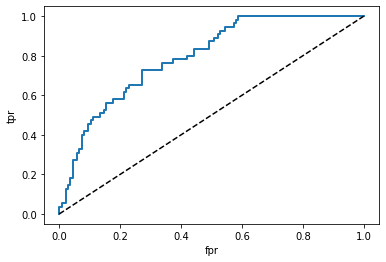

In [ ]:
import lightgbm as lgb

lr_params = {
    'base_estimator__num_leaves': randint(20, 100),
    'base_estimator__max_depth': [5, 10, 20, -1],
    'base_estimator__learning_rate': uniform(0.01, 0.1),
    'base_estimator__n_estimators': randint(50, 200),
    'base_estimator__subsample': uniform(0.6, 0.4),
    'base_estimator__colsample_bytree': uniform(0.6, 0.4),
    'base_estimator__min_child_samples': randint(20, 100),
    'base_estimator__reg_alpha': uniform(0, 1),
    'base_estimator__reg_lambda': uniform(0, 1),
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

lgb_model = lgb.LGBMClassifier()
bag_lgb = BaggingClassifier(base_estimator=lgb_model)

rs = RandomizedSearchCV(bag_lgb, lr_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
prob_y = rs_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')


Logistic Regression보다 아주 조금 낮은 값을 보여줌을 알 수 있다. 하지만 auc 값은 여전히 rfc를 통한 방식보다 높으므로 precision, recall 측면에서는 더 나은 성능을 보인다고 볼 수 있다.

* Random Forest + bagging (more params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 

최적 정확도: 0.6335078534031413
================= confusion matrix ====================
[[73 63]
 [ 7 48]]
정밀도: 0.43243243243243246, 재현율: 0.8727272727272727
AUC: 0.8295454545454546


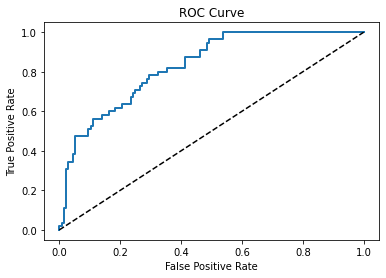

In [ ]:
rf_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, 30, None],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'base_estimator__max_features': ['auto', 'sqrt', 'log2'],
    'base_estimator__bootstrap': [True, False],
    'base_estimator__oob_score': [True, False],

    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

rf = RandomForestClassifier(random_state=42)
bag_rf = BaggingClassifier(base_estimator=rf, random_state=42)

rs = RandomizedSearchCV(bag_rf, rf_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)

print()

confusion = confusion_matrix(test_y, pred_y)
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')

precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)
print(f'정확도: {accuracy}', f'정밀도: {precision}, 재현율: {recall}')

prob_y = rs_best.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, prob_y)
auc = roc_auc_score(test_y, prob_y)

print(f'AUC: {auc}')

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

rfc 자체의 파라미터도 추가했을 경우, 원래의 rfc+bagging보다 재현율, AUC값이 훨씬 증가했다.

* split = 3, train_size=0.8

In [ ]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

n_cv = 3
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 

================= confusion matrix ====================
[[82 54]
 [12 43]]
정확도:0.6544502617801047, 정밀도:0.44329896907216493, 재현율:0.7818181818181819
auc:0.835294117647059


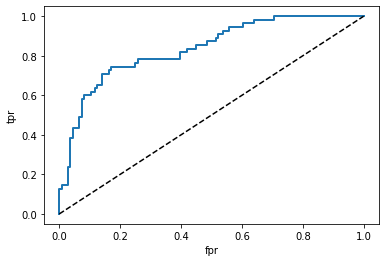

In [ ]:
lr_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

lr = LogisticRegression()
bag_lr = BaggingClassifier(base_estimator=lr)

rs = RandomizedSearchCV(bag_lr, lr_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
prob_y = rs_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')


* split=5, train_size=0.8

In [ ]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

n_cv = 5
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 

================= confusion matrix ====================
[[85 51]
 [ 9 46]]
정확도:0.6858638743455497, 정밀도:0.4742268041237113, 재현율:0.8363636363636363
auc:0.8482620320855614


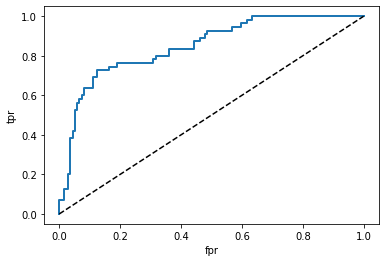

In [ ]:
lr_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

lr = LogisticRegression()
bag_lr = BaggingClassifier(base_estimator=lr)

rs = RandomizedSearchCV(bag_lr, lr_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
prob_y = rs_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')


split을 조정했을 때, 가장 높은 정확도였던 0.68의 정확도를 유지하면서 재현율과 auc값이 많이 상승했음을 볼 수 있다.

* split=6, train_size=0.8

In [ ]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

n_cv = 6
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 

================= confusion matrix ====================
[[83 53]
 [10 45]]
정확도:0.6701570680628273, 정밀도:0.45918367346938777, 재현율:0.8181818181818182
auc:0.8347593582887701


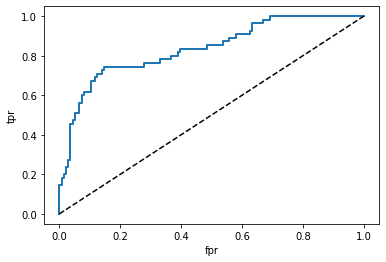

In [ ]:
lr_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

lr = LogisticRegression()
bag_lr = BaggingClassifier(base_estimator=lr)

rs = RandomizedSearchCV(bag_lr, lr_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
prob_y = rs_best.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

fpr, tpr, thresholds = roc_curve(test_y, prob_y[:, 1])
auc = roc_auc_score(test_y, prob_y[:, 1])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')


* split=5, train_size=0.8 + RandomForest+bagging

In [ ]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

n_cv = 5
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too 


================= confusion matrix ====================
[[78 58]
 [ 5 50]]
정확도: 0.6701570680628273 정밀도: 0.46296296296296297, 재현율: 0.9090909090909091
AUC: 0.8382352941176471


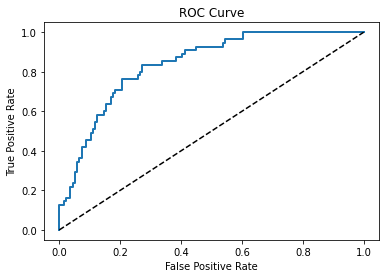

In [ ]:
rf_params = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, 30, None],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'base_estimator__max_features': ['auto', 'sqrt', 'log2'],
    'base_estimator__bootstrap': [True, False],
    'base_estimator__oob_score': [True, False],

    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

rf = RandomForestClassifier(random_state=42)
bag_rf = BaggingClassifier(base_estimator=rf, random_state=42)

rs = RandomizedSearchCV(bag_rf, rf_params, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)
rs.fit(train_x, train_y)

rs_best = rs.best_estimator_

rs_best.fit(train_x, train_y)

pred_y = rs_best.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)

print()

confusion = confusion_matrix(test_y, pred_y)
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')

precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)
print(f'정확도: {accuracy}', f'정밀도: {precision}, 재현율: {recall}')

prob_y = rs_best.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, prob_y)
auc = roc_auc_score(test_y, prob_y)

print(f'AUC: {auc}')

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

cv=5일때, train : test가 8:2일 때 가장 좋은 성능을 보여준다.

random forest + bagging에 적용시키면 재현율이 0.9로 가장 높음을 보여주지만, 정확도가 조금 떨어진다.

결론적으로, 가장 좋은 성능을 보여주는 모델은 cv = 5, train_size = 0.8, Logistic Regression과 Bagging을 결합한 모델이다.